In [1]:
import gdown
import os
import torch
import src
import notebooks
from notebooks.notebook_utils import *

In [2]:
pwd

'/data/wellawatte/catalysis_xai/boolformer/boolformer'

# Noiseless model

In [2]:
model_path = "boolformer_noiseless.pt" 
if not os.path.exists(model_path):
    url = "https://drive.google.com/uc?id=1cULlE16yKBqUZMMGv7CC5fgHXXJ7OQQQ"
    gdown.download(url, model_path, quiet=False)
boolformer = torch.load(model_path)
env = boolformer.env
print("Loaded pretrained model")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1cULlE16yKBqUZMMGv7CC5fgHXXJ7OQQQ
From (redirected): https://drive.google.com/uc?id=1cULlE16yKBqUZMMGv7CC5fgHXXJ7OQQQ&confirm=t&uuid=1664ad03-5e85-4606-a8b6-51a012400b95
To: /data/wellawatte/catalysis_xai/boolformer/boolformer/boolformer_noiseless.pt
100%|██████████| 434M/434M [00:10<00:00, 39.5MB/s] 


Loaded pretrained model


# Noisy model - for chem models (uncertain answers)

In [2]:
model_path = "boolformer_noisy.pt" 
if not os.path.exists(model_path):
    url = "https://drive.google.com/uc?id=1IFSc_sHfiTckMy-cwggvVMBH1YgXas8G"
    gdown.download(url, model_path, quiet=False)
boolformer = torch.load(model_path)
env = boolformer.env
print("Loaded pretrained model")

Loaded pretrained model


Problem: other


  0%|          | 0/5 [00:00<?, ?it/s]

Best f1: 0.699, acc: 0.728, complexity: 0
[$\substack{\text{Presence of} \\ \text{a C} \\ \text{bonded to} \\ \text{two O} \\ \text{atoms}}$ ]


bit123

 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

Best f1: 0.690, acc: 0.738, complexity: 1
[$\mathrm{and}$ [$\substack{\text{Presence of} \\ \text{a C=O} \\ \text{double bond}}$ ][$\substack{\text{Presence of} \\ \text{an O} \\ \text{with at} \\ \text{least two} \\ \text{chain bonds}}$ ]]


bit126 & bit154

 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

Best f1: 0.706, acc: 0.748, complexity: 3
[$\mathrm{not}$ [$\mathrm{or}$ [$\mathrm{not}$ [$\substack{\text{Presence of} \\ \text{an O} \\ \text{with at} \\ \text{least two} \\ \text{chain bonds}}$ ]][$\substack{\text{Presence of} \\ \text{two heteroatoms,} \\ \text{both attached} \\ \text{to at} \\ \text{least one} \\ \text{H and} \\ \text{seperated by} \\ \text{any 3} \\ \text{bonds}}$ ]]]


~(bit54 | ~bit126)

 60%|██████    | 3/5 [00:09<00:07,  3.53s/it]

Best f1: 0.713, acc: 0.786, complexity: 8
[$\mathrm{not}$ [$\mathrm{or}$ [$\substack{\text{Presence of} \\ \text{a hydroxy} \\ \text{oxygen (OH)}}$ ][$\mathrm{not}$ [$\substack{\text{Presence of} \\ \text{an O} \\ \text{with at} \\ \text{least two} \\ \text{chain bonds}}$ ]][$\mathrm{and}$ [$\mathrm{not}$ [$\substack{\text{Presence of} \\ \text{a C=O} \\ \text{double bond}}$ ]][$\mathrm{or}$ [$\mathrm{not}$ [$\substack{\text{Presence of} \\ \text{a hydroxy} \\ \text{oxygen (OH)}}$ ]][$\substack{\text{Presence of} \\ \text{an O} \\ \text{with at} \\ \text{least two} \\ \text{chain bonds}}$ ]]]]]


~(bit139 | ~bit126 | (~bit154 & (bit126 | ~bit139)))

 80%|████████  | 4/5 [00:15<00:04,  4.34s/it]

Best f1: 0.691, acc: 0.766, complexity: 7
[$\mathrm{not}$ [$\mathrm{or}$ [$\mathrm{not}$ [$\substack{\text{Presence of} \\ \text{an O} \\ \text{with at} \\ \text{least two} \\ \text{chain bonds}}$ ]][$\substack{\text{Presence of} \\ \text{an atom} \\ \text{bonded to} \\ \text{an N} \\ \text{and two} \\ \text{other atoms}}$ ][$\mathrm{not}$ [$\mathrm{or}$ [$\substack{\text{Presence of} \\ \text{a C=O} \\ \text{double bond}}$ ][$\mathrm{and}$ [$\substack{\text{Presence of} \\ \text{an O} \\ \text{with at} \\ \text{least two} \\ \text{chain bonds}}$ ][$\substack{\text{Presence of} \\ \text{an atom} \\ \text{bonded to} \\ \text{an N} \\ \text{and two} \\ \text{other atoms}}$ ]]]]]]


~(bit156 | ~bit126 | ~(bit154 | (bit126 & bit156)))

100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


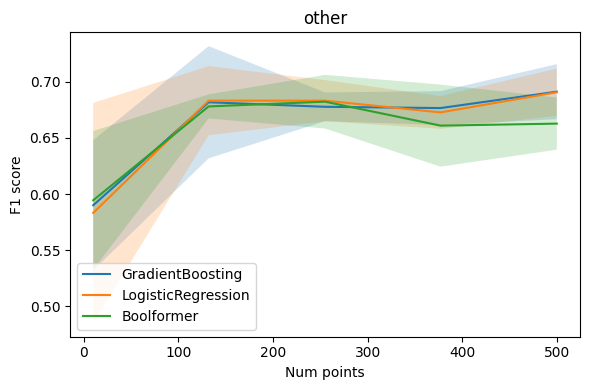

In [5]:
from notebook_utils import *

num_points = 100
beam_size  = 20
verbose = True
num_points_arr = np.linspace(10,500,5).astype(int)
#num_points_arr = [1,10,30]
problems = ['other']#['TOX','BBB']
fig, axarr = plt.subplots(1,len(problems),figsize=(6*len(problems),4))
for ip, problem in enumerate(problems):
    print('Problem:', problem, flush=True)
    accs, f1s, accs_var, f1s_var = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    for num_points in tqdm.tqdm(num_points_arr):
        accs_tmp, f1s_tmp, trees = defaultdict(list), defaultdict(list), []
        for seed in range(5):
            acc, f1, tree = run_drug_discovery(boolformer, data_path='/data/wellawatte/catalysis_xai/boolformer/bool_data', 
                                               problem=problem, num_points=num_points, 
                                               num_test_points=500, num_features=env.params.max_inactive_vars, beam_size=beam_size, 
                                               verbose=False, balance=True,usr_set='fruity_MACCS.csv')
            for k, v in acc.items(): accs_tmp[k].append(v)
            for k, v in f1.items(): f1s_tmp[k].append(v)
            trees.append(tree)
        # tree with best acc
        idx = np.argmax(f1s_tmp['Boolformer'])
        best_tree = trees[idx]
        best_f1, best_acc = f1s_tmp['Boolformer'][idx], accs_tmp['Boolformer'][idx]
        if verbose:
            print(f'Best f1: {best_f1:.3f}, acc: {best_acc:.3f}, complexity: {best_tree.get_n_ops()}')
            #print(f"[.${problem}$ "+tree_to_latex(best_tree)+"]", flush=True)
            #print(tree_to_latex(best_tree), flush=True)
            #display(env.simplifier.get_simple_infix(best_tree, simplify_form='basic'))
            latex_tree = tree_to_latex(best_tree)
            latex_tree = format_drug_discovery(latex_tree, key_path = os.path.join('/data/wellawatte/catalysis_xai/boolformer/bool_data/' 'key_maccs.csv'), problem=problem)
            print(latex_tree, flush=True)
            display(env.simplifier.get_simple_infix(best_tree, simplify_form='basic'))

        for k, v in accs_tmp.items(): 
            accs[k].append(np.mean(v))
            accs_var[k].append(np.std(v))
        for k, v in f1s_tmp.items(): 
            f1s[k].append(np.mean(v))
            f1s_var[k].append(np.std(v))

    if len(problems)!=1: ax = axarr[ip]   
    else: ax = axarr
    for k, v in f1s.items():
        ax.errorbar(num_points_arr, v,  label=k.replace('Classifier', ''))
        ax.fill_between(num_points_arr, np.array(v)-np.array(f1s_var[k]), np.array(v)+np.array(f1s_var[k]), alpha=0.2)
    ax.set_xlabel('Num points')
    ax.set_title(problem)

if len(problems)!=1: ax = axarr[0]   
else: ax = axarr
ax.set_ylabel('F1 score')
ax.legend()
plt.tight_layout()
#plt.savefig(savedir+'drug_discovery_maccs.pdf')
plt.show()

